# Segmentation of Indian Traffic

In [ ]:
!pip install -U --pre segmentation-models --user
!pip install tensorflow==2.2.0
!pip install keras==2.3.1
!pip install imgaug==0.4.0

In [1]:
import math
from PIL import Image, ImageDraw
from fnmatch import fnmatch
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import imgaug.augmenters as iaa
import json
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
from tqdm import tqdm
from sklearn.model_selection import train_test_split

<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [6]:
#created a unique id so i can merge them 
#in colab the file doesnt come sequetially so that why i created id 

def get_path_name(root):
    df=pd.DataFrame()
    images=os.listdir(f"data/{root}")
    list_of_images=[]
    scene=[]
    for img in images:
        for name in os.listdir(f"data/{root}/"+str(img)):
              list_of_images.append(f"data/{root}/"+str(img)+"/"+str(name))
              scene.append(str(img)+"/"+str(name.split("_")[0]))
    if root == 'images':
    df["images"]=list_of_images
    df["ID"]=scene
    else:
    df["json"]=list_of_images
    df["ID"]=scene
    return df 

In [7]:
def return_file_names_df():
    data_df = pd.DataFrame(columns=['image','json'])
    image_path=get_path_name('images')
    mask_path = get_path_name('mask')
    data_df=pd.merge(image_path,mask_path,on="ID",)
    data_df=data_df.drop("ID",axis=1)
    return data_df

In [8]:
data_df = return_file_names_df()
data_df.head(1)

,images,json
0,data/images/257/frame1169_leftImg8bit.jpg,data/mask/257/frame1169_gtFine_polygons.json


In [ ]:
print(data_df['images'][0])
print(data_df['json'][0])

data/images/353/frame4976_leftImg8bit.jpg
data/mask/353/frame4976_gtFine_polygons.json


> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [9]:
def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

In [10]:
grader_1(data_df)

True

In [11]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

In [9]:
def return_unique_labels(data_df):
    unique_labels=[]
    for i in data_df['json']:
        file = open(i)
        data = json.load(file)
        for label in data['objects']:
            for k,v in label.items():
                if k == 'label':
                    unique_labels.append(v)
        file.close()
    return unique_labels

In [10]:
unique_labels = return_unique_labels(data_df)

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [11]:
unique_labels = set(unique_labels)

In [2]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [ ]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [13]:
def get_poly(file):
    f = open(file)
    data = json.load(f)

    label = []
    vertexlist = []

    w = data["imgWidth"]
    h = data["imgHeight"]

    for objects in data["objects"]:
        l = []
        label.append(objects['label'])
        for i in objects['polygon']:
            l.append(tuple(i))
        vertexlist.append(l)

    f.close()
    
    return w, h, label, vertexlist

In [17]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

In [14]:
def compute_masks(data_df):
    all_path = []
    for i in tqdm(range(len(data_df))):
        w,h,label,vertexlist = get_poly(data_df['json'][i])
        img = Image.new('RGB',(w,h))
        img1 = ImageDraw.Draw(img)
        for j in range(len(label)):
            if len(vertexlist[j])>1:
                img1.polygon(vertexlist[j],label_clr[label[j]])
        img=np.array(img)
        im = Image.fromarray(img[:,:,0])
        
        subfolder_1=data_df['json'][i].split('/') #to get subpfolder number        
        if not (os.path.isdir(f'data/output/{subfolder_1[2]}')):
            os.mkdir(f'data/output/{subfolder_1[2]}')
                
        im.save(f"data/output/{subfolder_1[2]}/{subfolder_1[3][:-5]}.png")
        
        all_path.append(f'data/output/{subfolder_1[2]}/{subfolder_1[3][:-5]}.png')
        
    data_df['mask'] = all_path
    return data_df

In [15]:
data_df = compute_masks(data_df)
data_df.head()

100%|██████████| 4008/4008 [04:10<00:00, 15.98it/s]


,images,json,mask
0,data/images/257/frame1169_leftImg8bit.jpg,data/mask/257/frame1169_gtFine_polygons.json,data/output/257/frame1169_gtFine_polygons.png
1,data/images/257/frame0509_leftImg8bit.jpg,data/mask/257/frame0509_gtFine_polygons.json,data/output/257/frame0509_gtFine_polygons.png
2,data/images/257/frame0599_leftImg8bit.jpg,data/mask/257/frame0599_gtFine_polygons.json,data/output/257/frame0599_gtFine_polygons.png
3,data/images/257/frame0959_leftImg8bit.jpg,data/mask/257/frame0959_gtFine_polygons.json,data/output/257/frame0959_gtFine_polygons.png
4,data/images/257/frame1412_leftImg8bit.jpg,data/mask/257/frame1412_gtFine_polygons.json,data/output/257/frame1412_gtFine_polygons.png


True
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]


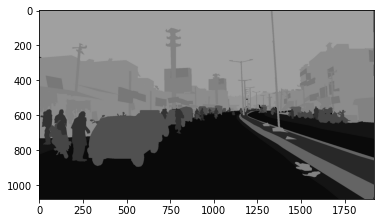

In [16]:
def grader_3():
    url = "https://i.imgur.com/4XSUlHk.png"
    url_response = urllib.request.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
    my_img = cv2.imread('data/output/201/frame0029_gtFine_polygons.png')    
    plt.imshow(my_img)
    print((my_img[:,:,0]==img).all())
    print(np.unique(img))
    print(np.unique(my_img[:,:,0]))
    data_df.to_csv('preprocessed_data.csv', index=False)
grader_3()

In [3]:
preprocess = pd.read_csv('preprocessed_data.csv')
preprocess.head(1)

,image,json,mask
0,data\images\201\frame0029_leftImg8bit.jpg,data\mask\201\frame0029_gtFine_polygons.json,data\output\201\frame0029_gtFine_polygons.png


In [5]:
X_train, X_test = train_test_split(preprocess[['image','mask']],test_size=0.1,random_state=42)

In [7]:
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [11]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()
    
def normalize_image(mask):
    mask = mask/255
    return mask

class Dataset:
  # CLASSES = list(np.unique(list(label_clr.values()))) 
  def __init__(self,data,aug=False):
#         self.ids = os.listdir(images_dir)
      self.images_fps = data['image'].tolist()
      self.masks_fps = data['mask'].tolist()
      
      # convert str names to class values on masks
      self.class_values = list(np.unique(list(label_clr.values())))
      self.aug = aug
  
  def __getitem__(self, i):
      
      # read data
      image = cv2.imread(self.images_fps[i],cv2.IMREAD_UNCHANGED)
      image = cv2.resize(image,(256,256),interpolation=cv2.INTER_NEAREST)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      
      mask = cv2.imread(self.masks_fps[i],cv2.IMREAD_UNCHANGED)
      mask = cv2.resize(mask,(256,256),interpolation=cv2.INTER_NEAREST)
      
      masks = [(mask == v) for v in self.class_values]
      mask = np.stack(masks, axis=-1).astype('float')
      
      if self.aug == True:
        a = np.random.uniform()
        if a<0.2:
            image = aug2.augment_image(image)
            mask = aug2.augment_image(mask)
        elif a<0.4:
            image = aug3.augment_image(image)
            mask = aug3.augment_image(mask)
        elif a<0.6:
            image = aug4.augment_image(image)
            mask = aug4.augment_image(mask)
        elif a<0.8:
            image = aug5.augment_image(image)
            mask = mask
        else:
            image = aug6.augment_image(image)
            mask = aug6.augment_image(mask)
        return image, mask
      else:
        return image,mask
      
  def __len__(self):
      return len(self.images_fps)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

### Task 2.1: Dice loss

<b>Formulation</b> : <math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mi>D</mi>
  <mi>i</mi>
  <mi>c</mi>
  <mi>e</mi>
  <mo>=</mo>
  <mfrac>
    <mrow class="MJX-TeXAtom-ORD">
      <mn>2</mn>
      <mrow>
        <mo>|</mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mi>A</mi>
          <mo>&#x2229;<!-- ∩ --></mo>
          <mi>B</mi>
        </mrow>
        <mo>|</mo>
      </mrow>
    </mrow>
    <mrow class="MJX-TeXAtom-ORD">
      <mrow>
        <mo>|</mo>
        <mi>A</mi>
        <mo>|</mo>
      </mrow>
      <mo>+</mo>
      <mrow>
        <mo>|</mo>
        <mi>B</mi>
        <mo>|</mo>
      </mrow>
    </mrow>
  </mfrac>
</math> 

<b>Range of the Loss Function </b> : The loss function range from 0 to 1

<b>Interpretation</b> : 

1. It is similarity measure between images. Measures the overlap between the two samples.
 
2. A∩B| represents the common elements between sets A and B, and |A| represents the number of elements in set A (and likewise for set B).
             
3. Here we are using IOU metric so to interpret the dice metric into loss function we do <b> 1 - DICE</b> so when the IOU metric will increase the dice will reduce

In [9]:
focal_loss = sm.losses.cce_dice_loss

In [ ]:
batch = 4
train_dataset = Dataset(X_train,aug=True)
test_dataset = Dataset(X_test,aug=False)

train_dataloader = Dataloder(train_dataset, batch_size=batch, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=batch, shuffle=True)

print(train_dataloader[0][0].shape,train_dataloader[0][1].shape)

assert train_dataloader[0][0].shape == (batch, 256, 256, 3)
assert train_dataloader[0][1].shape == (batch, 256, 256, 21)

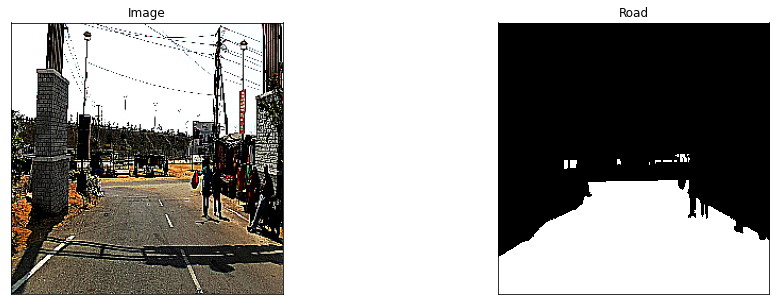

In [34]:
image, mask = train_dataset[25] # get some sample
visualize(
    image=image, 
    road=mask[...,1].squeeze(),
)

# Task 3: Training CANet

In [23]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

* as a part of this assignment we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: these filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

In [24]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], stride=1, name="conv block"):
        super().__init__(convolutional_block)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
        self.conv1 = Conv2D(self.F1,(1,1),strides=(self.stride,self.stride),padding='same',)
        self.conv2 = Conv2D(self.F2,(3,3),strides=(1,1),padding='same',)
        self.conv3 = Conv2D(self.F3,(1,1),strides=(1,1),padding='same',)
        self.conv4 = Conv2D(self.F3,(3,3),strides=(self.stride,self.stride),padding='same',)
        
        self.norm1 = BatchNormalization(axis=3)
        self.norm2 = BatchNormalization(axis=3)
        self.norm3 = BatchNormalization(axis=3)
        self.norm4 = BatchNormalization(axis=3)
        self.activate = Activation('relu')
        
        self.add = Add()
    def call(self, X):
        X_sum = X
        X = self.conv1(X)
        X = self.norm1(X)
        X = self.activate(X)
        
        X = self.conv2(X)
        X = self.norm2(X)
        X = self.activate(X)
        
        X = self.conv3(X)
        X = self.norm3(X)
        
        X_sum = self.conv4(X_sum)
        X_sum = self.norm4(X_sum)
        X_sum = self.activate(X_sum)
        X = self.add([X,X_sum])
        X = self.activate(X)
        return X

In [25]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], name="identity block"):
        super().__init__(identity_block)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.conv1 = Conv2D(self.F1,(1,1),strides=(1,1),padding='same',)
        self.conv2 = Conv2D(self.F2,(3,3),strides=(1,1),padding='same',)
        self.conv3 = Conv2D(self.F3,(1,1),strides=(1,1),padding='same',)
        
        self.norm1 = BatchNormalization(axis=3)
        self.norm2 = BatchNormalization(axis=3)
        self.norm3 = BatchNormalization(axis=3)
        
        self.activate = Activation('relu')
        
        self.add = Add()
    def call(self, X):
        X_sum = X
        
        X = self.conv1(X)
        X = self.norm1(X)
        X = self.activate(X)
        
        X = self.conv2(X)
        X = self.norm2(X)
        X = self.activate(X)
        
        X = self.conv3(X)
        X = self.norm3(X)
        
        X = self.add([X,X_sum])
        X = self.activate(X)
        return X

* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assignment we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [26]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self,f,height,width):
        super().__init__(global_flow)
        self.avg_pool = GlobalAveragePooling2D()
        self.norm = BatchNormalization(axis=3)
        self.activate = Activation('relu')
        self.conv1 = Conv2D(filters=f,kernel_size=(1,1),strides=(1,1),padding='same',)
        self.upsample = UpSampling2D(size =(height,width), interpolation='bilinear')
    def call(self, X):
        X = self.avg_pool(X)
        X = tf.expand_dims(X,1)
        X = tf.expand_dims(X,1)
        X = self.norm(X)
        X = self.activate(X)
        X = self.conv1(X)
        
        X = self.upsample (X)
        return X

In [27]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self,f,n):
        super().__init__(context_flow)
        self.concat = Concatenate()
        self.avg_pool = AveragePooling2D(pool_size=(n,n))
        self.conv1 = Conv2D(filters=f,kernel_size=(3,3),strides=(1,1),padding='same',)
        self.conv2 = Conv2D(filters=f,kernel_size=(3,3),strides=(1,1),padding='same',)
        self.conv3 = Conv2D(filters=f,kernel_size=(1,1),strides=(1,1),padding='same',)
        self.activate = Activation('relu')
        self.conv4 = Conv2D(filters=f,kernel_size=(1,1),strides=(1,1),padding='same',)
        self.sig = Activation('sigmoid')
        self.add = Add()
        self.mult = Multiply()
        self.upsample = UpSampling2D(size =(n,n), interpolation='bilinear')
    def call(self, X):
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        # implement the context flow as mentioned in the above cell
        X = self.concat([INP,FLOW])
        X = self.avg_pool(X)
        X = self.conv1(X)
        X = self.conv2(X)
        
        X_new = X
        X_new = self.conv3(X_new)
        X_new = self.activate(X_new)
        X_new = self.conv4(X_new)
        X_new = self.sig(X_new)
        
        X_new = self.mult([X,X_new])
        X_new = self.add([X,X_new])
        
        X_new = self.upsample(X_new)
        
        return X_new

* As shown in the above architecture we will be having 4 context flows
* if you have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.
 
<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

In [28]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self,f,height,width):
        super().__init__(fsm)
        self.conv1 = Conv2D(filters=f,kernel_size=(3,3),strides=(1,1),padding='same')
        self.avg_pool = GlobalMaxPooling2D()
        self.conv2 = Conv2D(filters=f,kernel_size=(1,1),strides=(1,1),padding='same')
        self.norm = BatchNormalization(axis=3)
        self.sig = Activation('sigmoid')
        self.mult = Multiply()
        self.upsample = UpSampling2D(size =(height,width), interpolation='bilinear')
    def call(self, X):
        # implement the FSM modules based on image in the above cells
        X = self.conv1(X)
        X_old = X
        
        X = self.avg_pool(X)
        X = tf.expand_dims(X,1)
        X = tf.expand_dims(X,1)
        
        X = self.conv2(X)
        X = self.norm(X)
        X = self.sig(X)
        
        X = self.upsample(X)
        FSM_Conv_T = self.mult([X_old,X])
        return FSM_Conv_T

* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

In [29]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self,f):
        super().__init__(agcn)
        self.conv1 = Conv2D(filters=f,kernel_size=(7,1),strides=(1,1),padding='same',activation='relu')
        self.conv2 = Conv2D(filters=f,kernel_size=(1,7),strides=(1,1),padding='same',activation='relu')
        self.conv3 = Conv2D(filters=f,kernel_size=(1,7),strides=(1,1),padding='same',activation='relu')
        self.conv4 = Conv2D(filters=f,kernel_size=(7,1),strides=(1,1),padding='same',activation='relu')
        self.conv5 = Conv2D(filters=f,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')
        self.add = Add()
    def call(self, X):
        # please implement the above mentioned architecture
        X_sh = X
        X = self.conv1(X)
        X = self.conv2(X)
        
        X_sh = self.conv3(X_sh)
        X_sh = self.conv4(X_sh)
        
        X_add = self.add([X,X_sh])
        
        X_new = self.conv5(X_add)
        
        final_X = self.add([X_add,X_new])
        return final_X

*     <img src='https://i.imgur.com/prH3Mno.png' width="600">
* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If you observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

In [30]:
X_input = Input(shape=(256,256,3))

# Stage 1
X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)
# print(X.shape)

X = convolutional_block(kernel=3,  filters=[4,4,8], stride=2)(X)
X_c1 = identity_block(kernel=3,  filters=[4,4,8])(X)

# print(X.shape)
X_c2 = convolutional_block(kernel=3,  filters=[8,8,16], stride=2)(X)
X =  identity_block(kernel=3,  filters=[8,8,16])(X_c2)
X = identity_block(kernel=3,  filters=[8,8,16])(X)

# print(X.shape)
X_c3 = convolutional_block(kernel=3,  filters=[16,16,32], stride=1)(X)
X = identity_block(kernel=3,  filters=[16,16,32])(X_c3)
X = identity_block(kernel=3,  filters=[16,16,32])(X)
X = identity_block(kernel=3,  filters=[16,16,32])(X)

# print(X.shape)
X_c4 = convolutional_block(kernel=3,  filters=[32,32,64], stride=1)(X)
X = identity_block(kernel=3,  filters=[32,32,64])(X_c4)
X = identity_block(kernel=3,  filters=[32,32,64])(X)
X = identity_block(kernel=3,  filters=[32,64,64])(X)
X = identity_block(kernel=3,  filters=[32,64,64])(X)
# print(X.shape)

X_gf  = global_flow(f=32,height=X.shape[-2],width=X.shape[-3])(X)
X_cf1 = context_flow(f=32,n=2)([X,X_gf])
X_cf2 = context_flow(f=32,n=2)([X,X_cf1])
X_cf3 = context_flow(f=32,n=2)([X,X_cf2])

# print(X_cf3.shape)

X_sum = Add()([X_gf,X_cf1,X_cf2,X_cf3])

X_fsm = fsm(f=32,height=X_sum.shape[-2],width=X_sum.shape[-3])(X_sum)
# print(X_fsm.shape)

X_agcn = agcn(f=32)(X_c1)
# print(X_agcn.shape)

fsm_up = UpSampling2D(size =(2,2), interpolation='bilinear')(X_fsm)

concat = Concatenate(axis=3)([X_agcn,fsm_up])

conv =  Conv2D(filters=21,kernel_size=(1,1),activation='relu',padding='same')(concat)

final = UpSampling2D(size =(4,4), interpolation='bilinear')(conv)

output = Activation('softmax')(final)

* If you observe the arcitecture we are creating a feature map with 2x time less width and height
* we have written the first stage of the code above.
* Write the next layers by using the custom layers we have written

In [31]:
canet_model = Model(inputs = X_input, outputs = output)

canet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           bn_conv1[0][0]                   
______________________________________________________________________________________________

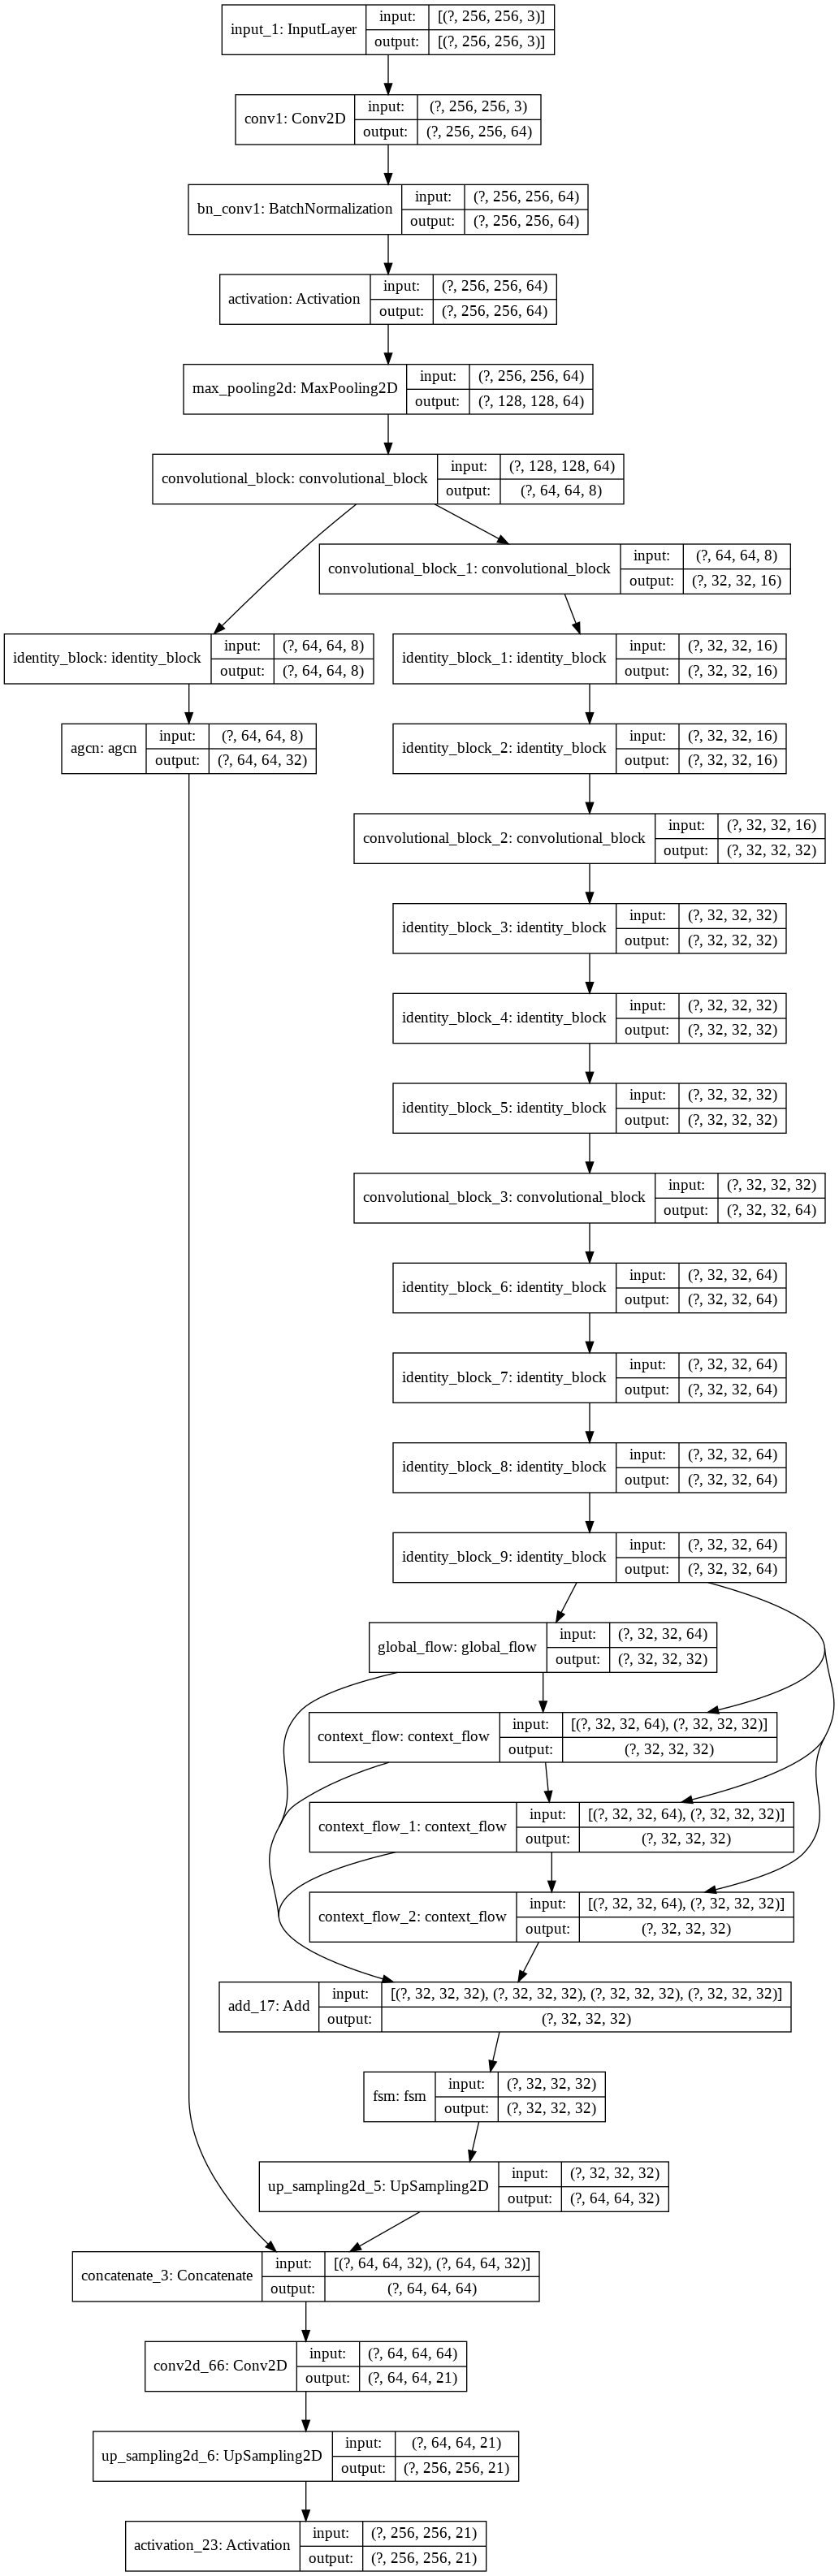

In [32]:
tf.keras.utils.plot_model(
    canet_model, to_file='model4.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [33]:
optim = tf.keras.optimizers.Adam()

focal_loss = sm.losses.cce_dice_loss

In [34]:
check= keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/Segmentation/canet.h5', save_weights_only=True, save_best_only=True,mode='max', monitor='val_iou_score')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', factor=0.2, patience=2, verbose=1, min_delta=1e-4, mode='min')

In [35]:
canet_model.compile(optim, focal_loss, metrics=[IOUScore(threshold=0.5)])
his = canet_model.fit(train_dataloader,validation_data=test_dataloader,epochs=5,verbose=1,callbacks=[check,reduce_lr_loss])

Epoch 1/5
901/901 [==============================] - 256s 285ms/step - loss: 0.9252 - iou_score: 0.3438 - val_loss: 0.8666 - val_iou_score: 0.3672 - lr: 0.0010
Epoch 2/5
901/901 [==============================] - 247s 275ms/step - loss: 0.8580 - iou_score: 0.3917 - val_loss: 0.8464 - val_iou_score: 0.3842 - lr: 0.0010
Epoch 3/5
901/901 [==============================] - ETA: 0s - loss: 0.8209 - iou_score: 0.4190
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
901/901 [==============================] - 246s 273ms/step - loss: 0.8209 - iou_score: 0.4190 - val_loss: 0.8239 - val_iou_score: 0.4007 - lr: 0.0010
Epoch 4/5
901/901 [==============================] - 252s 279ms/step - loss: 0.7775 - iou_score: 0.4507 - val_loss: 0.7996 - val_iou_score: 0.4176 - lr: 2.0000e-04
Epoch 5/5
901/901 [==============================] - ETA: 0s - loss: 0.7690 - iou_score: 0.4576
Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
901/901 [===

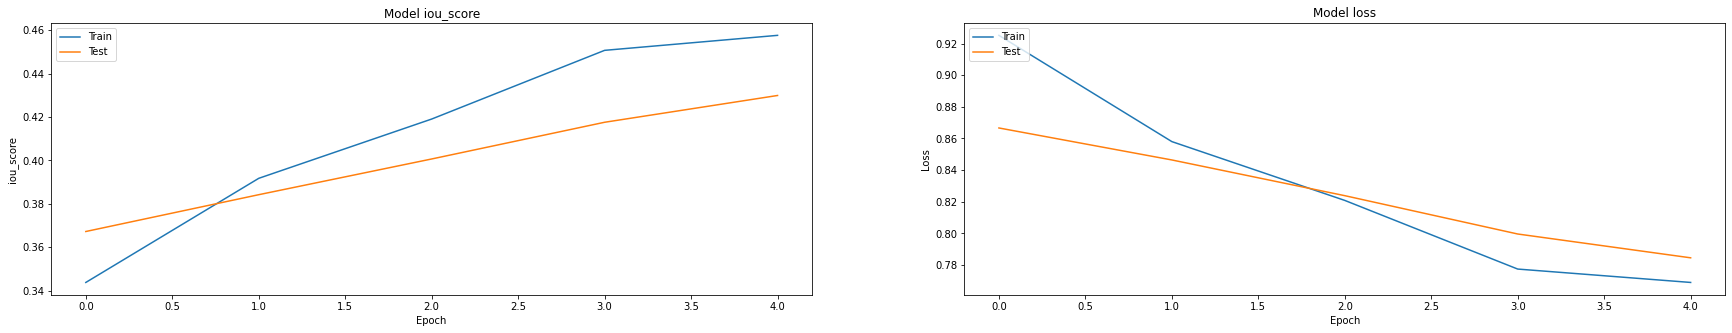

In [36]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(his.history['iou_score'])
plt.plot(his.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

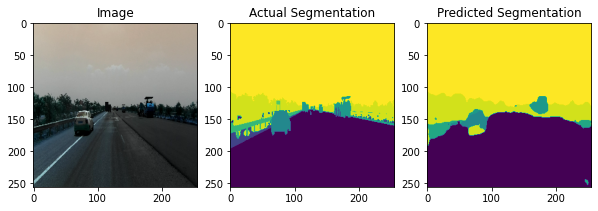

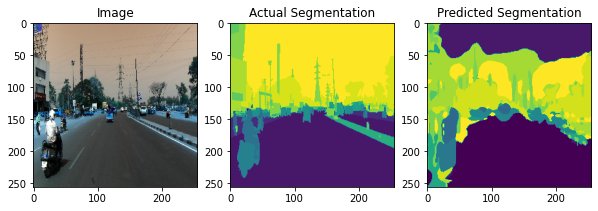

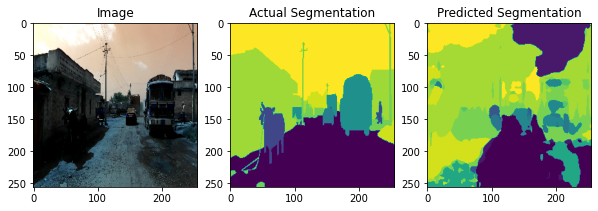

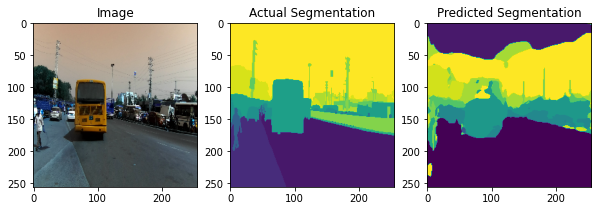

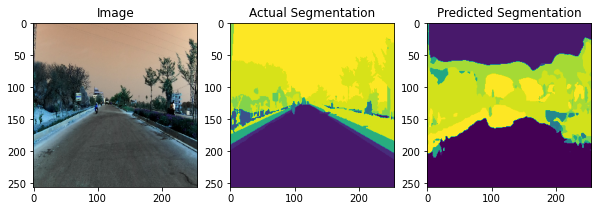

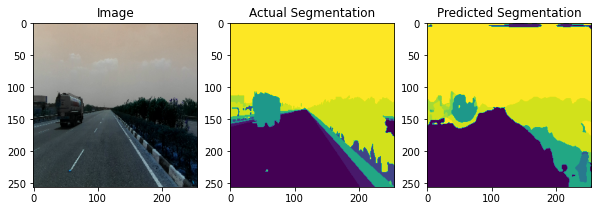

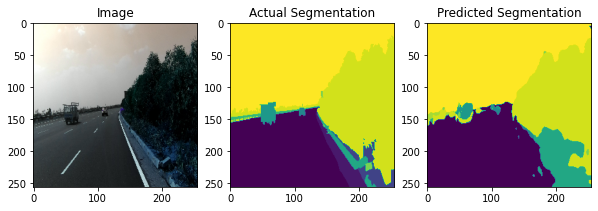

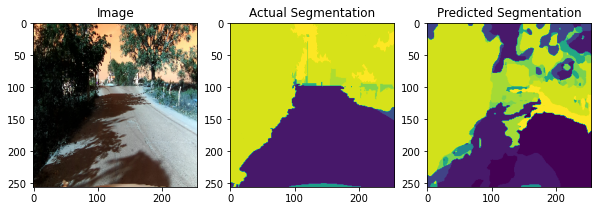

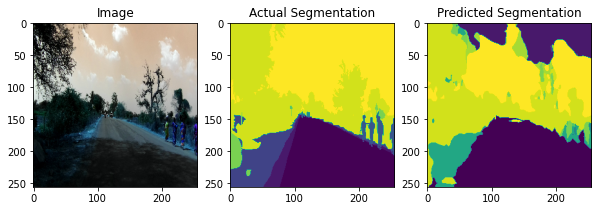

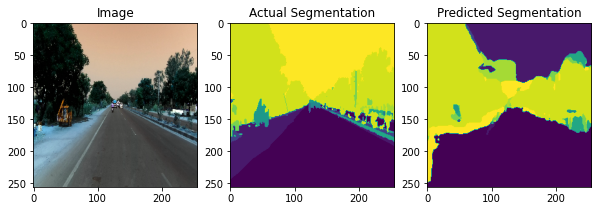

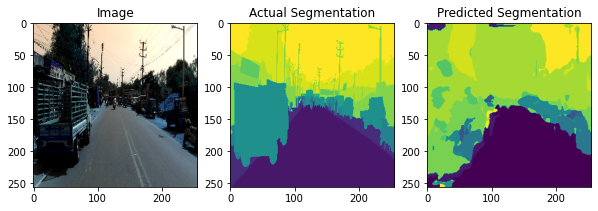

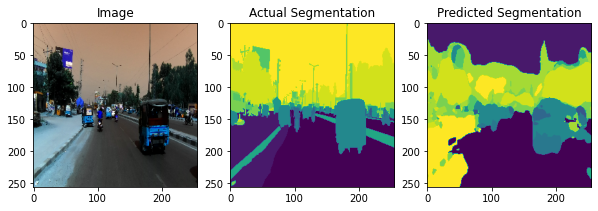

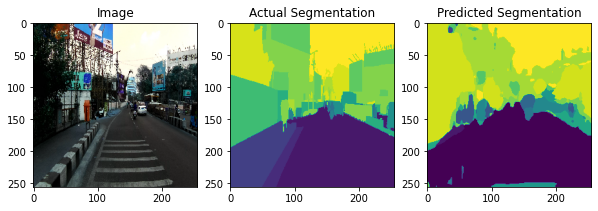

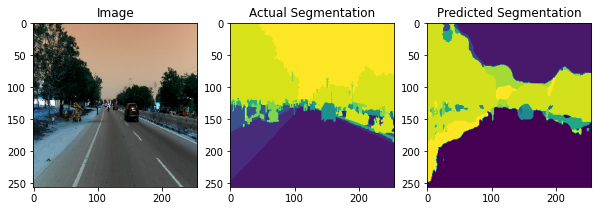

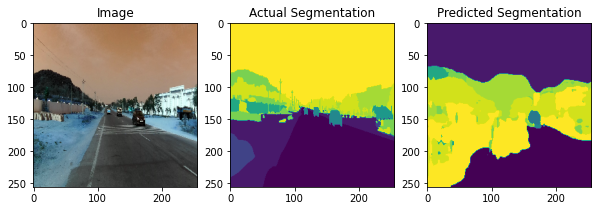

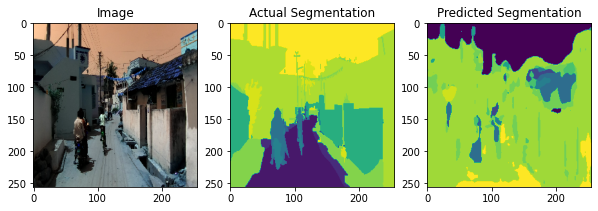

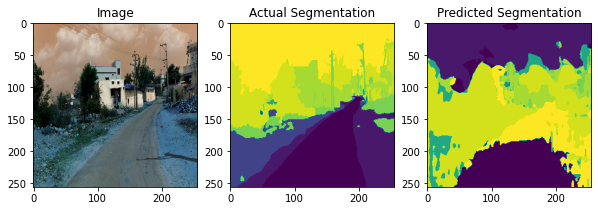

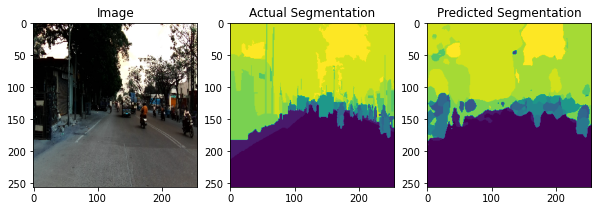

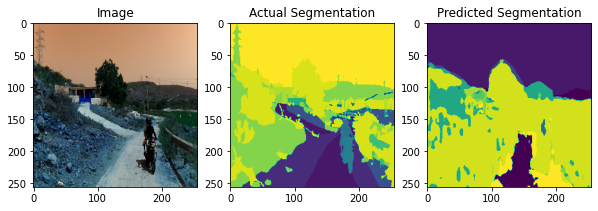

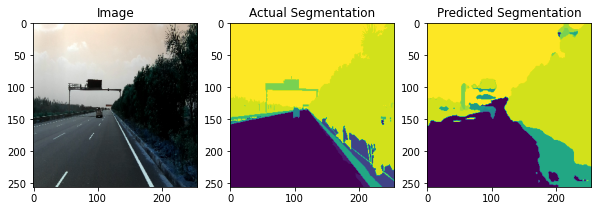

In [38]:
test_images = X_test.sample(n=20).index
for i in test_images:
  image = cv2.imread(X_test['images'][i], cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image,(256,256),interpolation = cv2.INTER_NEAREST)

  predicted = canet_model.predict(image[np.newaxis,:,:,:])
  predicted = tf.argmax(predicted,axis=-1)

  image_mask = cv2.imread(X_test['mask'][i], cv2.IMREAD_UNCHANGED)
  image_mask = cv2.resize(image_mask, (256,256),interpolation = cv2.INTER_NEAREST)
  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.imshow(image)
  plt.title('Image')
  plt.subplot(132)
  plt.imshow(image_mask)
  plt.title('Actual Segmentation')
  plt.subplot(133)
  plt.imshow(predicted[0])
  plt.title('Predicted Segmentation')
  plt.show()